In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from utils.utils import calc_sparsity
from latentcor import latentcor
from gglasso.problem import glasso_problem
from gglasso.helper.basic_linalg import scale_array_by_diagonal
from scipy.cluster.hierarchy import linkage

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
path_data_folder = '../data/preprocessed/MGH66_'
experiments = ["P1_untreated",
               "P2_meropenem",
               "P3_ciprofloxacin",
               "P4_gentamicin"]
suffix = "_preprocessed.h5ad"

In [3]:
adata_dict = {experiment: sc.read_h5ad(filename=path_data_folder+experiment+suffix) for experiment in experiments}
adata_dict

{'P1_untreated': AnnData object with n_obs × n_vars = 104250 × 3858
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
     var: 'gene', 'long_protein_name', 'species', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'gc5', 'gc1', 'gc0.5', 'gc0.1'
     layers: 'raw_counts', 'sqrt_counts',
 'P2_meropenem': AnnData object with n_obs × n_vars = 14113 × 3329
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
     var: 'gene', 'long_protein_name', 'species', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'gc5', 'gc

In [4]:
intersection_dict = dict()
filters = ['gc5', 'gc1', 'gc0.5', 'gc0.1']

for filter in filters:
    intersec = set(adata_dict["P1_untreated"].var.index[adata_dict["P1_untreated"].var[filter]]).intersection(
                set(adata_dict["P1_untreated"].var.index[adata_dict["P1_untreated"].var[filter]]),
                set(adata_dict["P3_ciprofloxacin"].var.index[adata_dict["P3_ciprofloxacin"].var[filter]]),
                set(adata_dict["P4_gentamicin"].var.index[adata_dict["P4_gentamicin"].var[filter]]))
    intersection_dict[filter] = intersec
    print(filter, len(intersec))

gc5 2
gc1 44
gc0.5 72
gc0.1 255


In [5]:
def create_S(adata_dict, intersection_dict, filter):

    for key in adata_dict.keys():
        adata = adata_dict[key][:,adata_dict[key].var.index.isin(intersection_dict[filter])].copy()
        sc.pp.filter_cells(adata, min_counts=1, inplace=True)
        adata_dict[key] = adata
    
    N = min([adata.shape[0] for adata in adata_dict.values()])
    S = dict()
    for idx, adata in enumerate(adata_dict.values()):
        adata = adata[adata.obs.sample(n=N, axis=0).index].copy()
        tps = ["tru"] * adata.shape[1]
        latent = latentcor(adata.layers["sqrt_counts"].A, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=False)
        S[idx] = latent["R"].to_numpy()
        print(idx, latent["R"].shape)
    return np.array(list(S.values())), N, adata_dict

In [6]:
S, N, filtered_adata_dict = create_S(adata_dict=adata_dict, intersection_dict=intersection_dict, filter=filters[1])

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


0 (44, 44)


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


1 (44, 44)


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


2 (44, 44)
3 (44, 44)


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


In [7]:
S = np.array([scale_array_by_diagonal(i) for i in S])
S.shape

(4, 44, 44)

In [8]:
N

7883

In [9]:
P = glasso_problem(S=S, N=N, reg_params={"lambda1": 0.05, "lambda2": 0.05}, latent=False, do_scaling=False)
print(P)

 
GROUP GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'lambda2': 0.05, 'mu1': None}


In [10]:
l1 = np.logspace(0,-5,20)
l2 = np.logspace(0,-5,20)
modelselect_params = {'lambda1_range' : l1, 'lambda2_range': l2}

P.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.9, tol=1e-7, rtol=1e-7)
print(P.reg_params)

ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminate

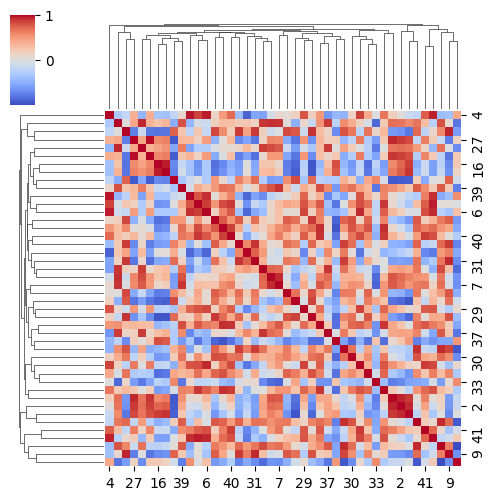

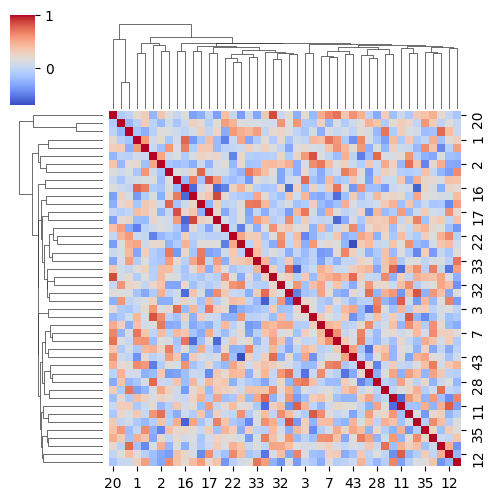

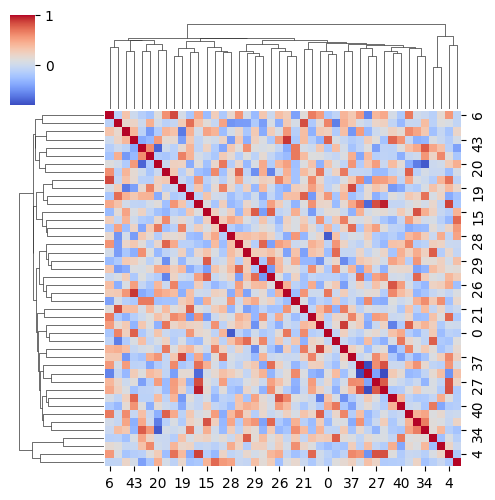

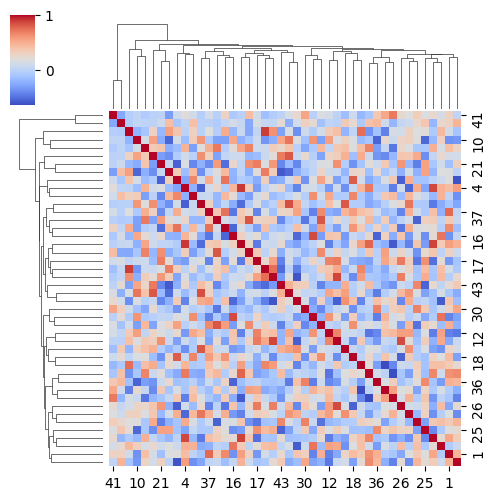

In [14]:
#linkage_list = [linkage(y=filtered_adata_dict[key].layers["sqrt_counts"].A.T, method="average", metric="euclidean") for key in filtered_adata_dict.keys()]
linkage_list = [linkage(y=S[i], method="average", metric="euclidean") for i in range(4)]
#fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i in range(4):
    A = scale_array_by_diagonal(P.solution.precision_[i])
    link = linkage_list[i]
    sns.clustermap(A, col_linkage=link, row_linkage=link, cmap="coolwarm", figsize=(5,5))

In [15]:
P = glasso_problem(S=S, N=N, reg_params={"lambda1": 0.05, "lambda2": 0.05}, latent=False, do_scaling=False)
print(P)

 
GROUP GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'lambda2': 0.05, 'mu1': None}


In [16]:
l1 = np.logspace(0,-5,20)
l2 = np.logspace(0,-5,20)
modelselect_params = {'lambda1_range' : l1, 'lambda2_range': l2}

P.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.5, tol=1e-7, rtol=1e-7)
print(P.reg_params)

ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminate

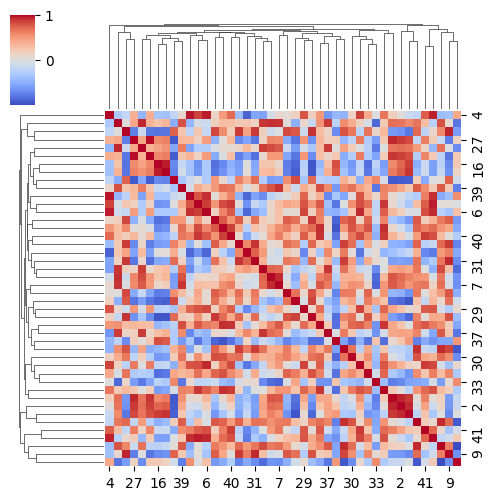

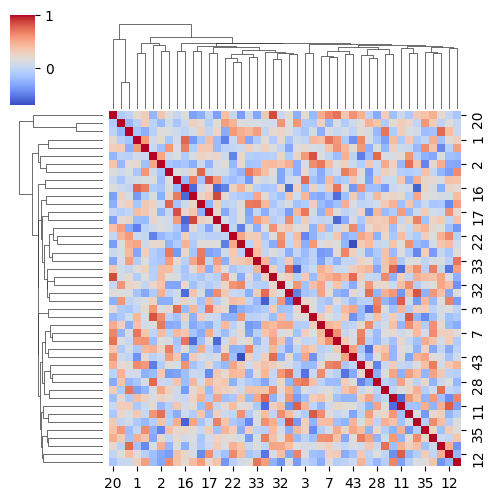

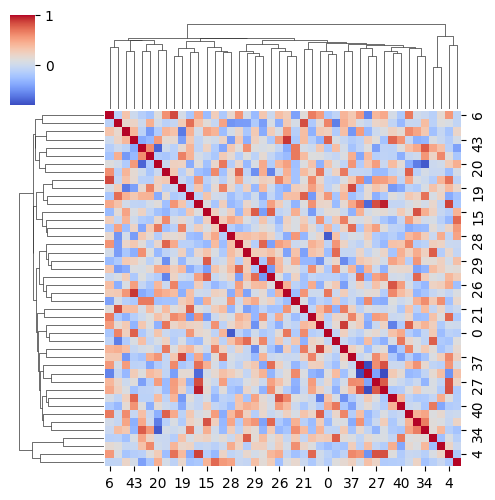

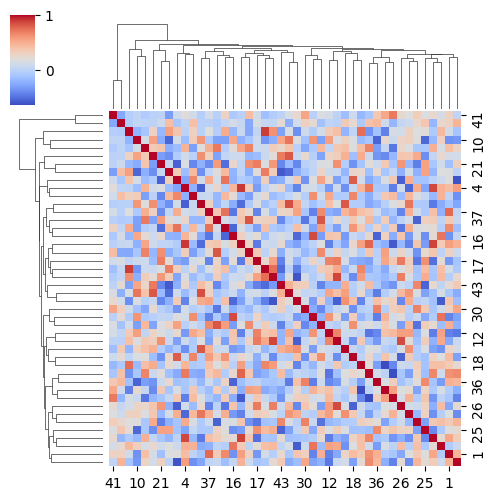

In [17]:
#linkage_list = [linkage(y=filtered_adata_dict[key].layers["sqrt_counts"].A.T, method="average", metric="euclidean") for key in filtered_adata_dict.keys()]
linkage_list = [linkage(y=S[i], method="average", metric="euclidean") for i in range(4)]
#fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i in range(4):
    A = scale_array_by_diagonal(P.solution.precision_[i])
    link = linkage_list[i]
    sns.clustermap(A, col_linkage=link, row_linkage=link, cmap="coolwarm", figsize=(5,5))

In [18]:
P = glasso_problem(S=S, N=N, reg_params={"lambda1": 0.05, "lambda2": 0.05}, latent=False, do_scaling=False)
print(P)

 
GROUP GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'lambda2': 0.05, 'mu1': None}


In [19]:
l1 = np.logspace(0,-5,20)
l2 = np.logspace(0,-5,20)
modelselect_params = {'lambda1_range' : l1, 'lambda2_range': l2}

P.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.1, tol=1e-7, rtol=1e-7)
print(P.reg_params)

ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminate

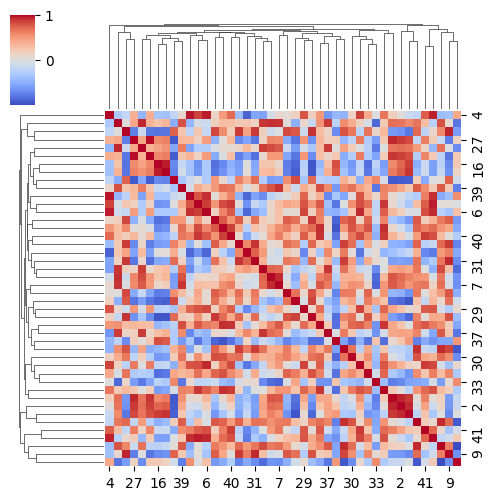

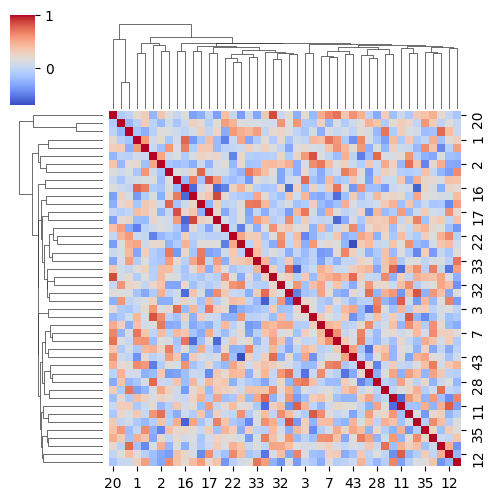

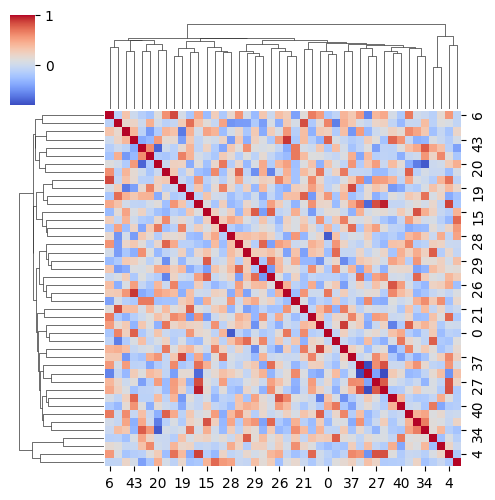

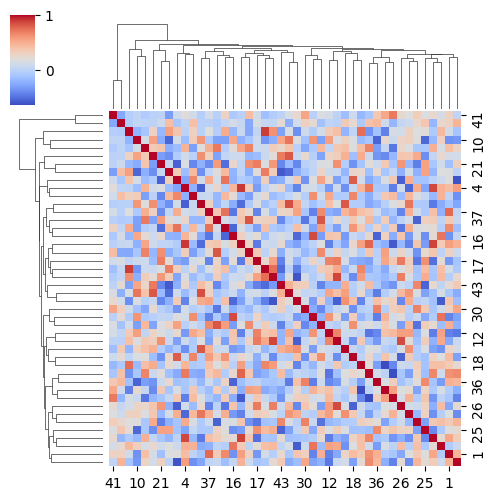

In [20]:
#linkage_list = [linkage(y=filtered_adata_dict[key].layers["sqrt_counts"].A.T, method="average", metric="euclidean") for key in filtered_adata_dict.keys()]
linkage_list = [linkage(y=S[i], method="average", metric="euclidean") for i in range(4)]
#fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i in range(4):
    A = scale_array_by_diagonal(P.solution.precision_[i])
    link = linkage_list[i]
    sns.clustermap(A, col_linkage=link, row_linkage=link, cmap="coolwarm", figsize=(5,5))

In [25]:
P.__dict__.keys()

dict_keys(['S', 'N', 'latent', 'G', 'do_scaling', 'conforming', 'multiple', 'K', 'p', 'reg_params', 'modelselect_params', 'reg', 'solution', 'modelselect_stats'])

In [27]:
P.modelselect_stats.keys()

dict_keys(['BIC', 'AIC', 'SP', 'RANK', 'TAU', 'L1', 'L2', 'BEST', 'GAMMA'])

In [35]:
P.modelselect_stats["GAMMA"]

[0.1, 0.5, 0.3, 0.9, 0.7]

In [36]:
P.modelselect_stats["BIC"].keys()

dict_keys([0.1, 0.5, 0.3, 0.9, 0.7])

In [49]:
P.modelselect_stats["BIC"][0.1]

array([[ 1.38740800e+06,  1.38740800e+06,  1.38740800e+06,
         1.38704900e+06,  1.38429876e+06,  1.38287403e+06,
         1.38212128e+06,  1.38171436e+06,  1.38149396e+06,
         1.38137416e+06,  1.38130901e+06,  1.38127350e+06,
         1.38125408e+06,  1.38124351e+06,  1.38123775e+06,
         1.38123464e+06,  1.38123292e+06,  1.38123199e+06,
         1.38123145e+06,  1.38123120e+06],
       [ 1.38740800e+06,  1.38740800e+06,  1.38314779e+06,
         1.37876681e+06,  1.37288516e+06,  1.36792525e+06,
         1.36414528e+06,  1.36161054e+06,  1.35998878e+06,
         1.35912143e+06,  1.35861405e+06,  1.35833874e+06,
         1.35818875e+06,  1.35810698e+06,  1.35806240e+06,
         1.35803808e+06,  1.35802481e+06,  1.35801758e+06,
         1.35801363e+06,  1.35801147e+06],
       [ 1.38740800e+06,  1.38646629e+06,  1.37792410e+06,
         1.35765414e+06,  1.33201060e+06,  1.30735967e+06,
         1.28844815e+06,  1.27556652e+06,  1.26804049e+06,
         1.26360253e+06,  1.2

In [ ]:
P.modelselect_stats["BIC"][0.3].shape

In [42]:
assert P.modelselect_stats["BIC"][0.3][0,0]  == P.modelselect_stats["BIC"][0.7][0,0]

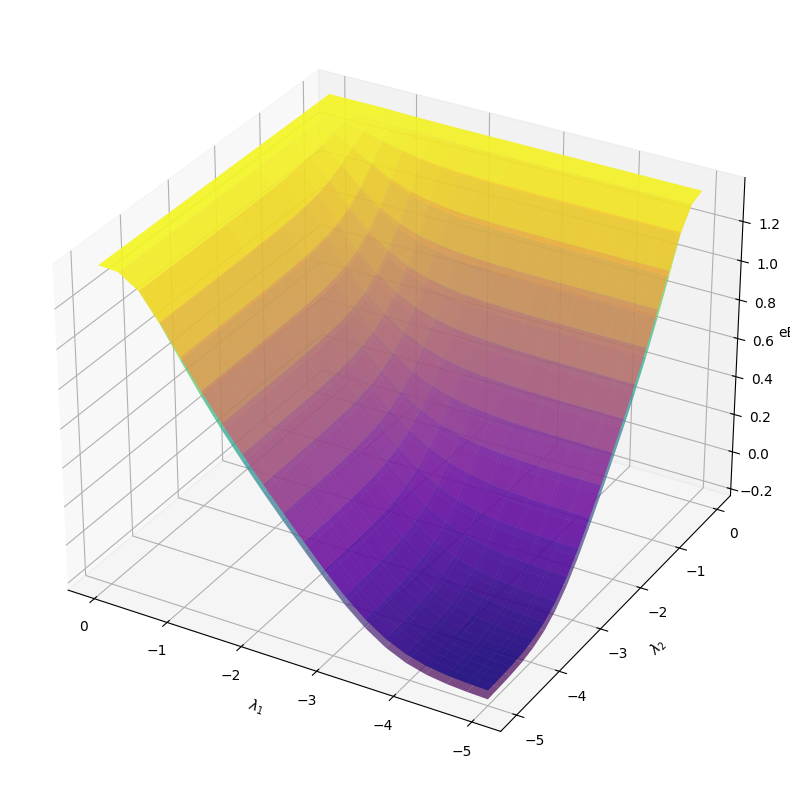

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate log-spaced values for lambda1 and lambda2
lambda1 = np.logspace(0, -5, 20)
lambda2 = np.logspace(0, -5, 20)

# Create a grid of lambda1 and lambda2 values
Lambda1, Lambda2 = np.meshgrid(lambda1, lambda2)

surface1 = P.modelselect_stats["BIC"][0.1]
surface2 = P.modelselect_stats["BIC"][0.9]

# Create the plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Plot the first surface
surf1 = ax.plot_surface(np.log10(Lambda1), np.log10(Lambda2), surface1, cmap='viridis', alpha=0.7)

# Plot the second surface
surf2 = ax.plot_surface(np.log10(Lambda1), np.log10(Lambda2), surface2, cmap='plasma', alpha=0.7)

ax.invert_xaxis()
#ax.invert_yaxis()

# Add labels
ax.set_xlabel('$\lambda_1$')
ax.set_ylabel('$\lambda_2$')
ax.set_zlabel('eBIC')

# Show the plot
plt.show()

<Axes: >

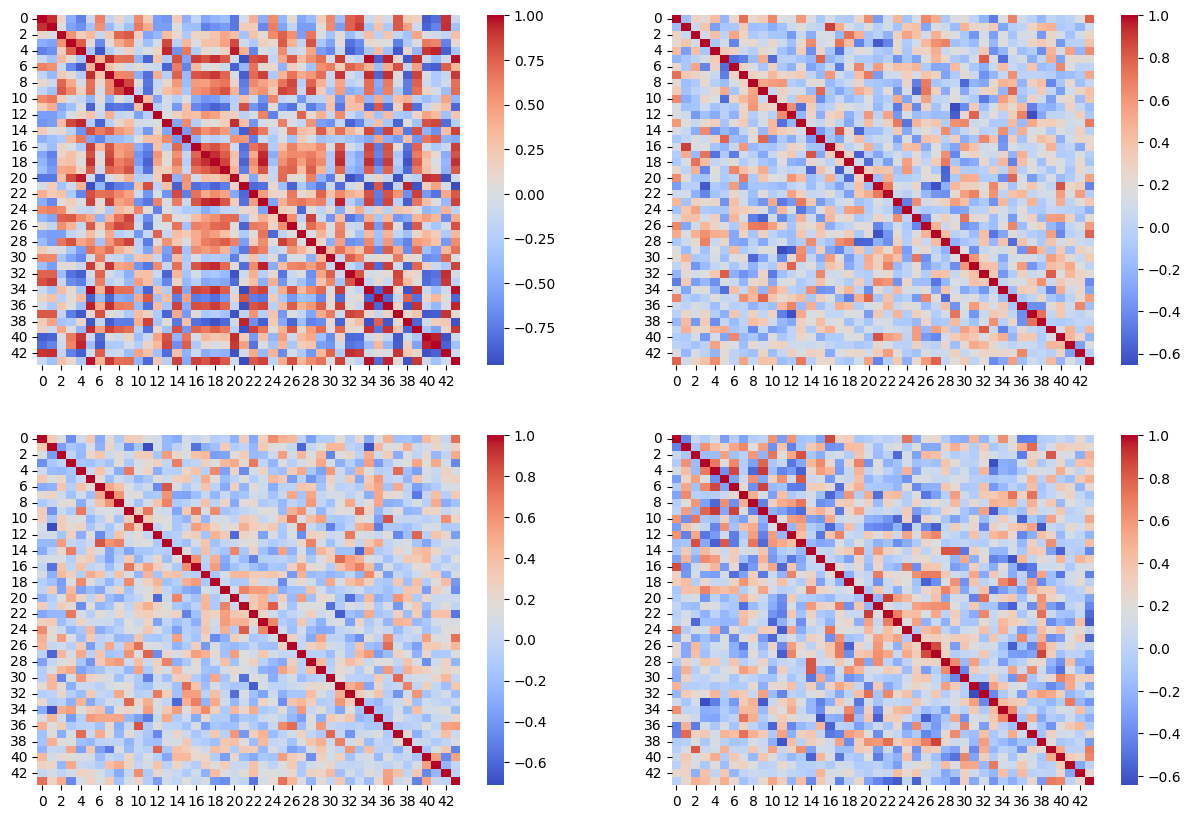

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.heatmap(scale_array_by_diagonal(P.solution.precision_[0]), ax=axes[0,0], cmap="coolwarm")
sns.heatmap(scale_array_by_diagonal(P.solution.precision_[1]), ax=axes[0,1], cmap="coolwarm")
sns.heatmap(scale_array_by_diagonal(P.solution.precision_[2]), ax=axes[1,0], cmap="coolwarm")
sns.heatmap(scale_array_by_diagonal(P.solution.precision_[3]), ax=axes[1,1], cmap="coolwarm")

In [87]:
filtered_adata_dict["P1_untreated"].var.loc[~filtered_adata_dict["P1_untreated"].var["rRNA"]]

,gene,long_protein_name,species,protein_name,rRNA,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_counts,gc5,gc1,gc0.5,gc0.1
cds-WP_002885441.1,WP_002885441.1,WP_002885441.1 MULTISPECIES: chaperonin GroEL ...,Klebsiella,MULTISPECIES: chaperonin GroEL,False,10818,0.027295,0.026929,97.362383,11195.0,9.323312,5148.0,False,True,True,True
cds-WP_002888731.1,WP_002888731.1,WP_002888731.1 MULTISPECIES: dihydrolipoyl deh...,Klebsiella,MULTISPECIES: dihydrolipoyl dehydrogenase,False,17141,0.044007,0.043066,95.820726,18049.0,9.800901,8212.0,False,True,True,True
cds-WP_002898408.1,WP_002898408.1,WP_002898408.1 MULTISPECIES: porin OmpA [Klebs...,Klebsiella,MULTISPECIES: porin OmpA,False,26499,0.070361,0.067996,93.539083,28858.0,10.270177,14028.0,True,True,True,True
cds-WP_002899276.1,WP_002899276.1,WP_002899276.1 MULTISPECIES: 23S rRNA accumula...,Klebsiella,MULTISPECIES: 23S rRNA accumulation protein YceD,False,10125,0.025764,0.025438,97.531349,10567.0,9.265586,4917.0,False,True,True,True
cds-WP_002901243.1,WP_002901243.1,WP_002901243.1 MULTISPECIES: glyceraldehyde-3-...,Klebsiella,MULTISPECIES: glyceraldehyde-3-phosphate dehyd...,False,11297,0.028653,0.028251,97.245595,11752.0,9.371863,5684.0,False,True,True,True
cds-WP_002910407.1,WP_002910407.1,WP_002910407.1 MULTISPECIES: ribose-phosphate ...,Enterobacteriaceae,MULTISPECIES: ribose-phosphate diphosphokinase,False,5066,0.012698,0.012618,98.764821,5208.0,8.558144,2477.0,False,True,True,True
cds-WP_002914147.1,WP_002914147.1,WP_002914147.1 MULTISPECIES: tRNA (guanosine(3...,Enterobacteriaceae,MULTISPECIES: tRNA (guanosine(37)-N1)-methyltr...,False,15748,0.040091,0.039308,96.160364,16443.0,9.707716,7604.0,False,True,True,True
cds-WP_002919219.1,WP_002919219.1,WP_002919219.1 MULTISPECIES: DNA-directed RNA ...,Bacteria,MULTISPECIES: DNA-directed RNA polymerase subu...,False,36791,0.099131,0.094520,91.029714,40658.0,10.612975,19360.0,True,True,True,True
cds-WP_002919515.1,WP_002919515.1,WP_002919515.1 MULTISPECIES: preprotein transl...,Bacteria,MULTISPECIES: preprotein translocase subunit SecY,False,40562,0.110515,0.104824,90.110279,45327.0,10.721681,20676.0,True,True,True,True
cds-WP_002920103.1,WP_002920103.1,WP_002920103.1 MULTISPECIES: elongation factor...,Klebsiella,MULTISPECIES: elongation factor G,False,59854,0.171474,0.158263,85.406553,70329.0,11.160954,33303.0,True,True,True,True
